In [1]:
import numpy as np, matplotlib.pyplot as plt
from tdse import Grid3D, make_vortex_beam, make_gaussian_beam
from tdse import SplitStep, circle_mask, apply_plane_mask
from tdse import intensity_plane, radial_average
from tdse.units import m_e, suggest_dt, k0_from_energy
from tdse.runner import run, make_edge_mask


In [2]:
# Electron energy (change as you like)
E_eV = 100.0  # 100 eV electrons (λ ≈ 0.12 nm)

# Grid in meters (keep small to start)
Nx, Ny, Nz = 96, 96, 128
dx = dy = 2e-9     # 2 nm
dz = 2e-9          # 2 nm

grid = Grid3D(Nx, Ny, Nz, dx, dy, dz)

# Choose one: Gaussian (l=0) or vortex (l=1)
# state = make_gaussian_beam(grid, E_eV, waist=20e-9, z0=-150e-9)
state = make_vortex_beam(grid, E_eV, waist=20e-9, z0=-150e-9, ell=1)

# Time step from heuristic
dt = suggest_dt(dx, dy, dz, mass=m_e, phase_limit=0.25*np.pi)
prop = SplitStep(grid, m_e, dt)

# Boundary absorbing mask (simple cosine^p)
M = make_edge_mask(grid, width_cells=10, power=6)

# Report basics
print("λ (nm) ≈", 1e9*2*np.pi/k0_from_energy(E_eV))
print("dt (fs) ≈", dt*1e15)



λ (nm) ≈ 0.12263659691673819
dt (fs) ≈ 5.499116969958433


In [3]:
z_screen = 0.0               # screen plane (m)
R = 150e-9                   # aperture radius (150 nm)
smooth = 2*dx                # soft edge ≈ 2 cells

Axy = circle_mask(grid.x, grid.y, center=(0.0, 0.0), radius=R, smooth=smooth)

def drop_screen_event(state_obj):
    # multiply the plane at z=z_screen by the aperture A(x,y)
    apply_plane_mask(state_obj.psi, grid, z_screen, Axy)


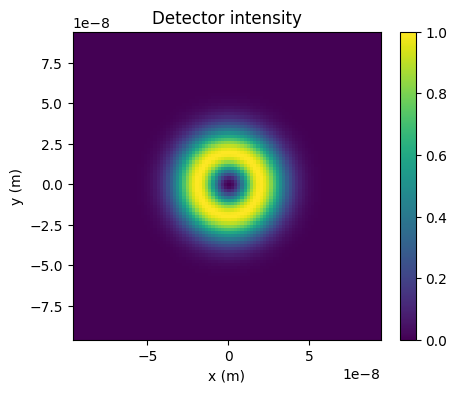

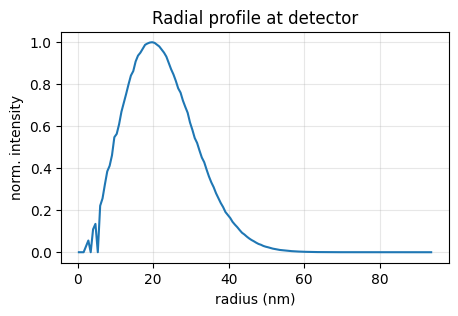

In [4]:
z_det = +300e-9             # detector plane downstream
steps = 300                 # ~ set by how far you want to propagate

frames = {}                 # optional: stash slices for animation later
def measure(step, st):
    # save mid-plane slice every 10 steps (optional, for animation)
    if step % 10 == 0:
        k_mid = grid.Nz//2
        frames[step] = np.abs(st.psi[:,:,k_mid])**2

# Schedule the aperture to apply once when we reach the screen plane.
# For simplicity, apply near the start (e.g., step 10).
events = [(10, drop_screen_event)]

run(state, prop, steps=steps, V_half=None, boundary_mask=M, events=events, on_measure=measure)

# Detector readout
x, y, img = intensity_plane(state.psi, grid, z_det)
plt.figure(figsize=(5,4))
plt.imshow(img.T/np.max(img), origin="lower", extent=[x[0],x[-1],y[0],y[-1]], aspect="equal")
plt.xlabel("x (m)"); plt.ylabel("y (m)"); plt.title("Detector intensity")
plt.colorbar(); plt.show()

# Radial average (quick “signal”)
r, prof = radial_average(x, y, img, nbins=150)
plt.figure(figsize=(5,3))
plt.plot(r*1e9, prof/np.max(prof))
plt.xlabel("radius (nm)"); plt.ylabel("norm. intensity")
plt.title("Radial profile at detector"); plt.grid(alpha=0.3); plt.show()
